In [2]:
import os
import sys
import pickle
import numpy as np
import pickle
from tqdm import trange
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold
import xgboost as xgb
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, kendalltau

from human_eval.data import HUMAN_EVAL, read_problems, stream_jsonl, write_jsonl

In [3]:
NUM_TASKS = 164

In [4]:
def calc_mtd(dgms):
    dgm0 = dgms[0]
    dgm1 = dgms[1]
    
    mtd0 = np.sum(dgm0[dgm0 < np.inf])
    if dgm1.shape[0]:
        mtd1 = np.sum(dgm1[:, 1] - dgm1[:, 0])
    else:
        mtd1 = 0
    
    return mtd0, mtd1

results = {}
results_code = {}

for i in trange(NUM_TASKS):
    results1 = pickle.load(open('/he_results2/%d.pickle' % i, 'rb'))
    results_code1 = pickle.load(open('/he_results2/%d_code.pickle' % i, 'rb'))

    # prompt_len, correct_prefixes[seq], diag_sum1, diag_sum2, cross_barc(P, G), cross_barc(G, P)       first arg in cross_barcode -> 0 

    for k, v in results1.items():
        dgms_a, dgms_b = v[-2]['dgms'], v[-1]['dgms']
        results1[k] = v[:4] + [calc_mtd(dgms_a), calc_mtd(dgms_b)]

    # prompt_len, correct_prefixes[seq], diag_sum1, diag_sum2, (mtd0(P, G), mtd1(P, G)), (mtd0(G, P), mtd1(G, P))       first arg in cross_barcode -> 0 

    results.update(results1)
    results_code.update(results_code1)

In [5]:
#pickle.dump((results, results_code), open('/he_results2/all.pickle', 'wb'))
(results, results_code) = pickle.load(open('/he_results2/all.pickle', 'rb'))

In [6]:
samples = []
num_samples_per_task = 5

In [7]:
for task_num in range(NUM_TASKS):
    task_id = 'HumanEval/%d' % task_num
    for seed in range(5):
        for i in range(num_samples_per_task):
            samples.append(dict(task_id = task_id, completion = results_code[(task_id, seed)][0][i]))

In [8]:
write_jsonl("samples_he.jsonl", samples)

In [9]:
!evaluate_functional_correctness samples_he.jsonl

Reading samples...
4100it [00:00, 25185.89it/s]
Running test suites...
100%|███████████████████████████████████████| 4100/4100 [01:05<00:00, 62.34it/s]
Writing results to samples_he.jsonl_results.jsonl...
100%|████████████████████████████████████| 4100/4100 [00:00<00:00, 44520.33it/s]
{'pass@1': 0.25951219512195123, 'pass@10': 0.6066208313050164}


In [10]:
run_stat = [[] for _ in range(NUM_TASKS)]

for elem in stream_jsonl('samples_he.jsonl_results.jsonl'):
    task_id = elem['task_id']
    task_num = int(task_id.split('/')[-1])

    run_stat[task_num].append(int(elem['passed']))

In [11]:
run_stat

[[1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0],
 [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1],
 [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,

In [12]:
np.sum(run_stat), np.mean(run_stat)

(1064, 0.25951219512195123)

### Random split

In [21]:
Y = []

for elem in stream_jsonl('samples_he.jsonl_results.jsonl'):
    task_id = elem['task_id']
    task_num = int(task_id.split('/')[-1])

    Y.append(int(elem['passed']))

In [22]:
def get_probs():
    all_probs = []

    for task_num in range(NUM_TASKS):
        features = []
        task_id = 'HumanEval/%d' % task_num
        for seed in range(5):
            for seq in range(5):
                prompt_len = results[(task_id, 0, 0, 0, 0)][0]
                answer_len = results[(task_id, seed, seq, 0, 0)][1] - prompt_len
                f_sample = [prompt_len, answer_len]
                probs = results_code[(task_id, 0)][2][seq]            
                probs = probs[prompt_len:prompt_len + answer_len]
                        
                all_probs.append(np.mean(np.log(probs)))
    
    return np.array(all_probs)

In [23]:
task_list = []

for task_num in range(NUM_TASKS):
    task_id = 'HumanEval/%d' % task_num
    for seed in range(5):
        for seq in range(5):
            task_list.append((task_id, seed, seq))

In [24]:
all_probs = get_probs()

In [25]:
len(all_probs)

4100

In [26]:
def prepare_features():
    all_features = []

    for task_num in trange(NUM_TASKS):
        features = []
        task_id = 'HumanEval/%d' % task_num
        for seed in range(5):
            for seq in range(num_samples_per_task):

                # prompt_len, correct_prefixes[seq], diag_sum(prompt), diag_sum(answer), (mtd0(P, G), mtd1(P, G)), (mtd0(G, P), mtd1(G, P))  first arg in cross_barcode -> 0 

                prompt_len = results[(task_id, 0, 0, 0, 0)][0]
                answer_len = results[(task_id, seed, seq, 0, 0)][1] - prompt_len
                f_sample = [prompt_len, answer_len] 
                
                for layer in range(32):
                    for head in range(32):
                        f = results[(task_id, seed, seq, layer, head)]
                        f = [f[2] / prompt_len, f[3] / answer_len, f[4][0] / answer_len, f[4][1] / answer_len, f[5][0] / prompt_len , f[5][1] / prompt_len]
                        f_sample.extend(f)
                        
                all_features.append(f_sample)
    
    return all_features

In [27]:
f_names = ['prompt_len', 'answer_len']
cnt = 2

f = ['prompt_self_att', 'answer_self_att', 'mtd_a_h0', 'mtd_a_h1', 'mtd_b_h0', 'mtd_b_h1']
        
for layer in range(32):
    for head in range(32):
        for f1 in f:
            f_names.append('%d_%s_%d_%d' % (cnt, f1, layer, head))
            cnt += 1

In [28]:
X = prepare_features()
X = np.array(X)
Y = np.array(Y)

100%|██████████| 164/164 [01:08<00:00,  2.39it/s]


In [29]:
X.shape, len(Y)

((4100, 6146), 4100)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
#X = np.array(inter_llm_he_res).reshape((len(inter_llm_he_res), 1))

### XGBoost

### Transfer learning

In [ ]:
#X = np.concatenate((X, all_probs.reshape((X.shape[0], 1))), axis = 1)
#X = all_probs.reshape((X.shape[0], 1))

In [ ]:
X.shape

In [ ]:
%%time

clf = xgb.XGBClassifier(tree_method="hist", max_bin = 64, n_estimators = 1000, eta = 0.1).fit(X, Y)
#clf = xgb.XGBClassifier(tree_method="hist").fit(X, Y)
clf.save_model('he.xgb')

In [88]:
clf.load_model('mbpp.xgb')

In [89]:
roc_auc_score(Y, clf.predict_proba(X)[:,1])

0.7912803253192269

In [90]:
f1_score(Y, clf.predict(X))

0.2868277474668745

### Cross-validate XGBoost

In [30]:
%%time

clf_obj = xgb.XGBClassifier(tree_method="hist")
cv_res = cross_validate(clf_obj, X, Y, scoring = 'f1', cv = KFold(n_splits = 5, shuffle = True, random_state = 42))

CPU times: user 1h 12min 58s, sys: 4min 14s, total: 1h 17min 13s
Wall time: 1min 57s


In [31]:
np.mean(cv_res['test_score'])

0.7892556934060243

In [34]:
cv_res

{'fit_time': array([22.75028872, 22.09167171, 23.78819942, 24.28408766, 24.66239882]),
 'score_time': array([0.02863312, 0.02439904, 0.0272243 , 0.02317882, 0.03101993]),
 'test_score': array([0.82      , 0.79581152, 0.76041667, 0.79802956, 0.77202073])}

### Feature importance

In [31]:
clf = xgb.XGBClassifier(tree_method="hist").fit(X_train, y_train)

In [32]:
for elem in sorted(list(enumerate(zip(clf.feature_importances_, f_names))), key = lambda x : -abs(x[1][0])):
    print(elem)

(883, (0.083762296, '883_mtd_b_h1_4_18'))
(1771, (0.030059105, '1771_mtd_b_h1_9_6'))
(3480, (0.024027063, '3480_mtd_b_h0_18_3'))
(5046, (0.017560802, '5046_mtd_b_h0_26_8'))
(565, (0.016925057, '565_mtd_b_h1_2_29'))
(2387, (0.012411811, '2387_mtd_a_h1_12_13'))
(1197, (0.010636199, '1197_answer_self_att_6_7'))
(4130, (0.010560111, '4130_prompt_self_att_21_16'))
(4324, (0.010126483, '4324_mtd_a_h0_22_16'))
(5836, (0.009237929, '5836_mtd_a_h0_30_12'))
(5394, (0.008264814, '5394_mtd_b_h0_28_2'))
(3642, (0.008203504, '3642_mtd_b_h0_18_30'))
(2685, (0.008023199, '2685_answer_self_att_13_31'))
(2554, (0.007583815, '2554_mtd_a_h0_13_9'))
(2041, (0.0069797593, '2041_mtd_b_h1_10_19'))
(1408, (0.0066111675, '1408_mtd_a_h0_7_10'))
(3248, (0.006255605, '3248_prompt_self_att_16_29'))
(5904, (0.005989524, '5904_mtd_b_h0_30_23'))
(4391, (0.005897255, '4391_mtd_a_h1_22_27'))
(2268, (0.0058041313, '2268_mtd_b_h0_11_25'))
(3525, (0.0055731647, '3525_answer_self_att_18_11'))
(6045, (0.0054166997, '6045_ans

In [33]:
import shap

In [34]:
explainer = shap.TreeExplainer(clf.get_booster())
shap_values = explainer.shap_values(X_test)

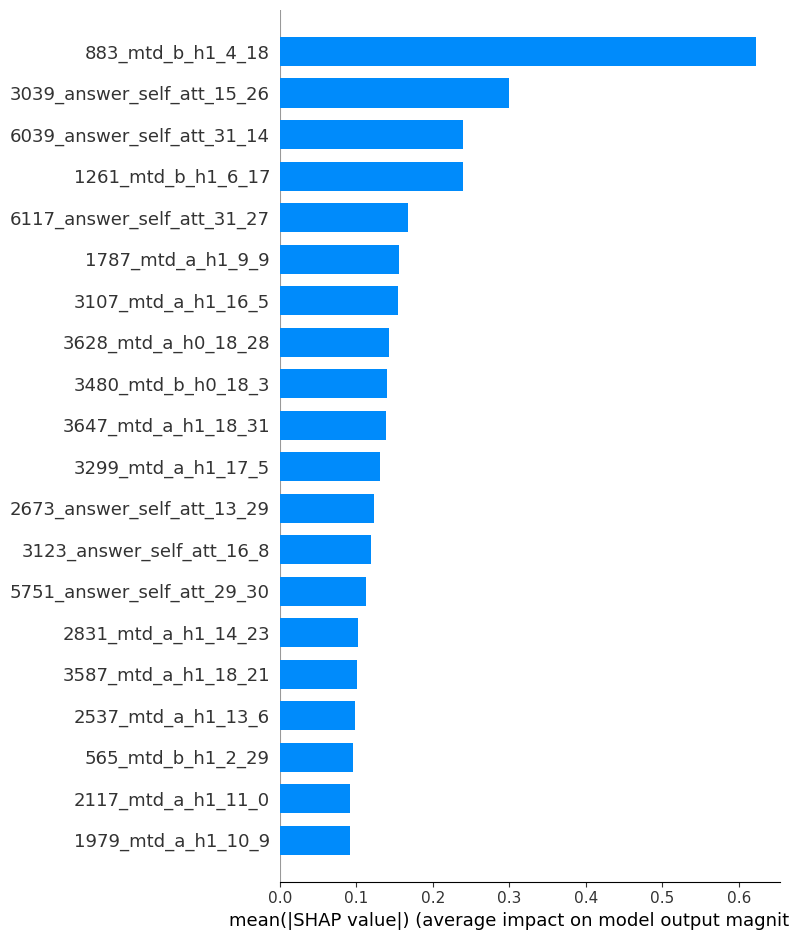

In [35]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names = f_names)

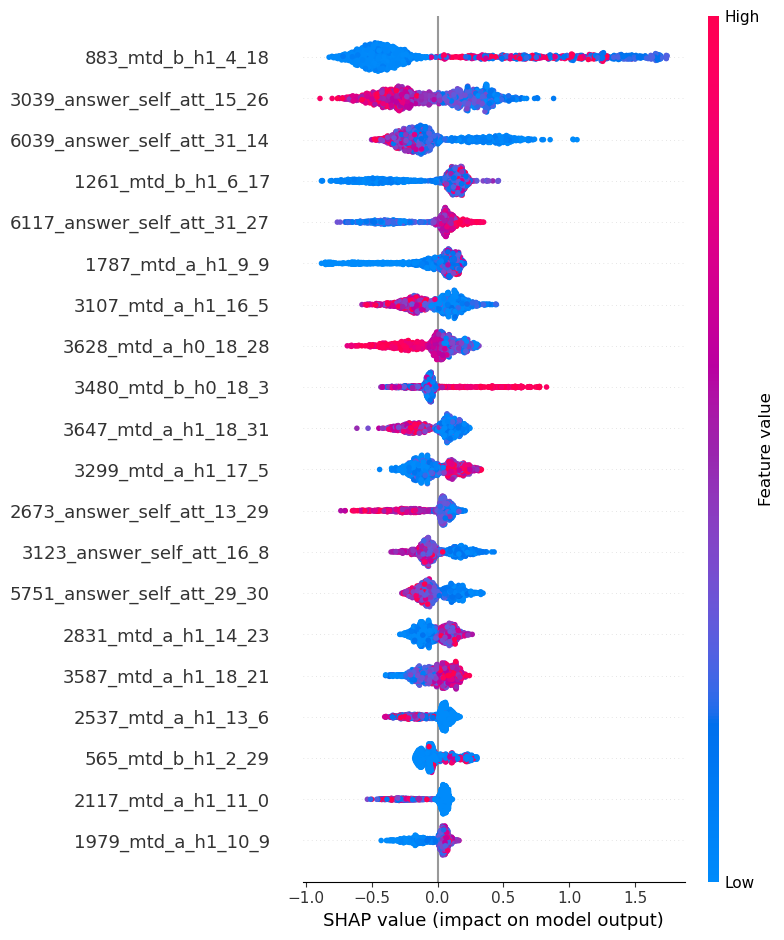

In [36]:
shap.summary_plot(shap_values, X_test, feature_names = f_names)

In [41]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

def plot5hist(num_list):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    for i in range(5):
        plot_feature_hist(axes[i], num_list[i])

def plot_feature_hist(ax, num):
    A = list(zip(X_scaled[:, num], Y))
    idx, mtd, kind, h, layer, head = f_names[num].split('_')

    if mtd == 'mtd':

        if h[1] == '1':
            step = 0.01
        else:
            step = 0.05
        
        B = [z[0] for z in list(filter(lambda x : x[1] == 1, A))]
        ax.hist(B, bins = np.arange(0., 1., step), alpha = 0.5, density = True, label = '1')
        
        B = [z[0] for z in list(filter(lambda x : x[1] == 0, A))]
        ax.hist(B, bins = np.arange(0., 1., step), alpha = 0.5, density = True, label = '0')
    else:
        B = [z[0] for z in list(filter(lambda x : x[1] == 1, A))]
        ax.hist(B, bins = np.arange(0., 1., 0.05), alpha = 0.5, density = True, label = '1')
        
        B = [z[0] for z in list(filter(lambda x : x[1] == 0, A))]
        ax.hist(B, bins = np.arange(0., 1., 0.05), alpha = 0.5, density = True, label = '0')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xlim(-5, 5.1)
    
    h = h[1]
    ax.set_xlim(-0.01, 1.01)
    if mtd == 'mtd':
        if h == '1':
            ax.set_xlim(-0.01, 0.25)
        name = 'MTD$_%s$(%s),layer=%s,head=%s' % (h, "P,G" if kind == 'a' else 'G,P', layer, head)
    else:
        name = 'sum_diag(%s),layer=%s,head=%s' % ("P" if kind == 'P' else 'G', layer, head)
    ax.set_xlabel(name)
    ax.legend(loc='best')
    #plt.show()

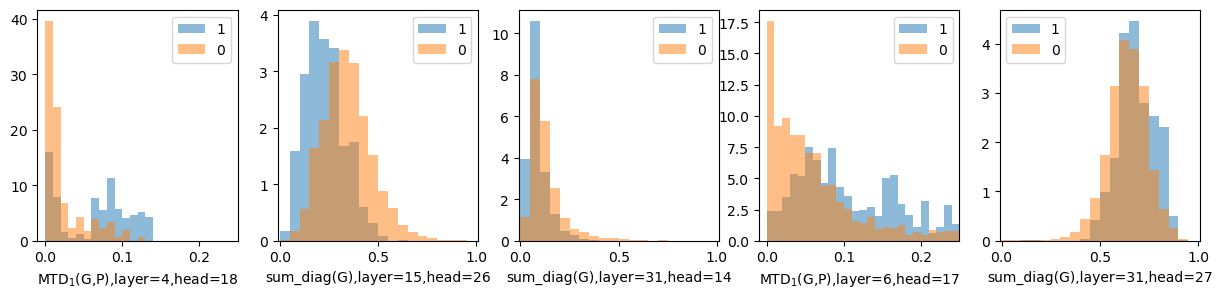

In [42]:
plot5hist([883, 3039, 6039, 1261, 6117])

In [39]:
#plot5hist([883, 6039, 3480, 1264, 1337])

In [40]:
#plot5hist([2831, 4745, 847, 2179, 3815])

### Single feature correlations

In [43]:
data = []

def nan2zero(x):
    if np.isnan(x):
        return 0.
    else:
        return x
        
for i in range(X_train.shape[1]):
    #data.append((nan2zero(kendalltau(X_train[:, i], y_train).statistic), i, f_names[i]))
    data.append((roc_auc_score(Y, X[:, i]) - 0.5, i, f_names[i]))

In [45]:
sorted(data, key = lambda x : -np.abs(x[0]))

[(0.2737465266426937, 541, '541_mtd_b_h1_2_25'),
 (0.269565960355434, 2179, '2179_mtd_b_h1_11_10'),
 (-0.2668679170752969, 3039, '3039_answer_self_att_15_26'),
 (0.26535103197717613, 366, '366_mtd_b_h0_1_28'),
 (0.26159302653867866, 2414, '2414_prompt_self_att_12_18'),
 (0.2612690632212944, 601, '601_mtd_b_h1_3_3'),
 (0.26087436352739557, 340, '340_mtd_a_h0_1_24'),
 (0.2605983833100538, 342, '342_mtd_b_h0_1_24'),
 (0.26044762350540396, 3476, '3476_prompt_self_att_18_3'),
 (0.2597102316066847, 171, '171_answer_self_att_0_28'),
 (0.259093880947428, 847, '847_mtd_b_h1_4_12'),
 (0.25841995056811995, 2444, '2444_prompt_self_att_12_23'),
 (0.2574971272053652, 1051, '1051_mtd_b_h1_5_14'),
 (0.2572900259542136, 356, '356_prompt_self_att_1_27'),
 (-0.2569111142480708, 298, '298_mtd_a_h0_1_17'),
 (0.2564789567793, 51, '51_answer_self_att_0_8'),
 (0.25630714632430873, 2396, '2396_prompt_self_att_12_15'),
 (-0.2562682954916936, 300, '300_mtd_b_h0_1_17'),
 (0.25622480113326784, 799, '799_mtd_b_h1_4

In [46]:
pickle.dump(data, open('he_corr.pickle', 'wb'))

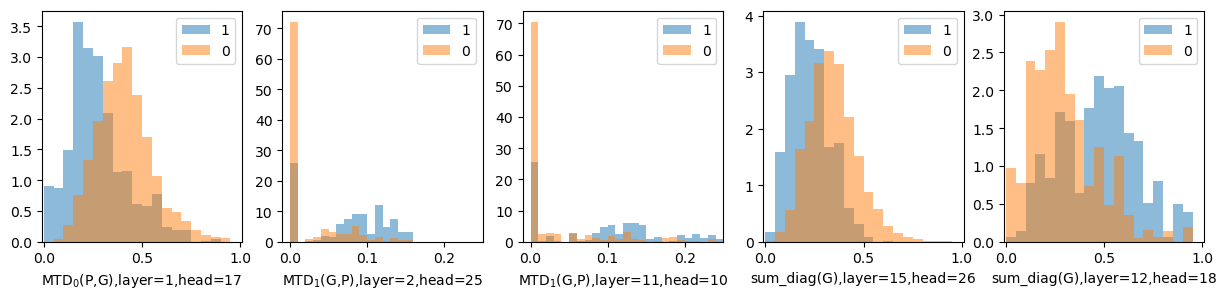

In [47]:
plot5hist([298, 541, 2179, 3039, 2414])

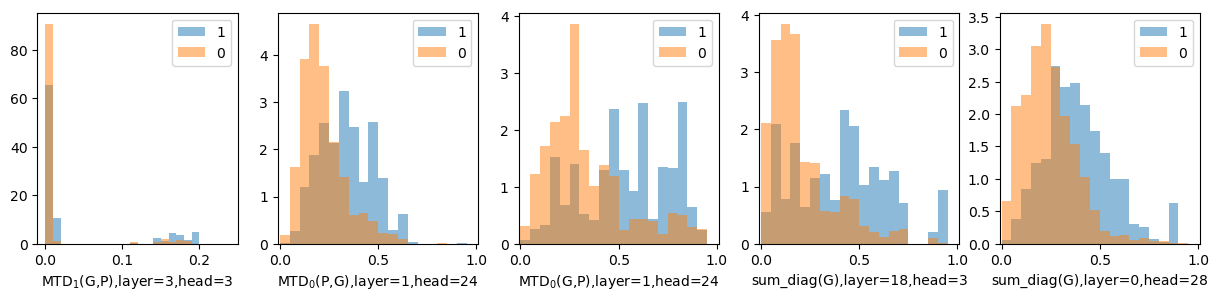

In [48]:
plot5hist([601, 340, 342, 3476, 171])

### Split by task

In [85]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [86]:
#inter_llm_he_res = pickle.load(open('/hcode/inter_llm_he_res.pickle', 'rb'))
#X = np.array(inter_llm_he_res).reshape((len(inter_llm_he_res), 1))

In [87]:
#self_eval_he_res = pickle.load(open('/hcode/self_eval_he_res.pickle', 'rb'))
#X = np.array([int(x == 'A') for x in self_eval_he_res]).reshape((len(self_eval_he_res), 1))

In [88]:
def calc_quality_group(train_idx, test_idx):

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    probs_train = []
    probs_test = []

    test_info = []
    test_task_nums = set()
    
    for i in range(X.shape[0]):
        if i in train_idx:
            X_train.append(X[i])
            y_train.append(Y[i])
            probs_train.append(all_probs[i])
        else:
            X_test.append(X[i])
            y_test.append(Y[i])
            test_info.append(i // 25)
            probs_test.append(all_probs[i])
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    #
    # scaling is optional
    #
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #X_train = np.array(probs_train).reshape(len(probs_train), 1)
    #X_test = np.array(probs_test).reshape(len(probs_test), 1)

    print(X_train.shape)
    print(X_test.shape)

    ##clf = xgb.XGBClassifier(tree_method="hist", max_bin = 64, n_estimators = 100, eta = 0.1)
    #clf = MLPClassifier(hidden_layer_sizes=(256, 256, 256), max_iter = 2000, early_stopping = True)
    #clf = LogisticRegression(max_iter=1000)
    #clf = SVC(probability=True)
    #clf = DecisionTreeClassifier(max_depth = 1)
    #thres = get_opt_threshold(X_train, y_train)
    
    clf.fit(X_train, y_train)    

    ##plot_fi(clf)
    
    y_pred = clf.predict_proba(X_test)[:,1]
    y_pred_class = clf.predict(X_test)

    # fixed features
    #y_pred = X_test[:, 2740]
    #y_pred_class = [int(x > 0.5) for x in y_pred]
    
    #y_pred = probs_test
    #y_pred_class = [int(x > 0.5) for x in probs_test]

    #y_pred = X_test[:, 0]
    #y_pred_class = [int(x > thres) for x in X_test[:, 0]]

    #
    #
    #
    task_res = {task_num : [] for task_num in set(test_info)}

    for i in range(len(test_info)):
        task_num = test_info[i]
        p = y_pred[i]
        task_res[task_num].append((p, y_test[i]))

    all_candidates = []

    for task_num in task_res:
        pred_list = task_res[task_num]
        pred_list_sorted = sorted(pred_list, key = lambda x : -x[0])
        #best_candidate = [x[1] for x in pred_list_sorted[0:1]]
    
        all_candidates.append(pred_list_sorted)

    return roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred_class), all_candidates, clf

In [89]:
groups = []

for i in range(NUM_TASKS):
    for j in range(25):
        groups.append(i)

kf = StratifiedGroupKFold(n_splits = 5, shuffle = True, random_state = 42)
res_auc = []
res_f1 = []
all_task_res = []
all_clf = []

for train_idx, test_idx in kf.split(range(X.shape[0]), Y, groups):
    #print("%s %s" % (train_idx, test_idx))
    auc, f1, task_res, clf = calc_quality_group(train_idx, test_idx)
    res_auc.append(auc)
    res_f1.append(f1)
    all_task_res.append(task_res)
    all_clf.append(clf)

(3275, 6146)
(825, 6146)
(3275, 6146)
(825, 6146)
(3275, 6146)
(825, 6146)
(3275, 6146)
(825, 6146)
(3300, 6146)
(800, 6146)


In [95]:
print(res_auc)

[0.8101524335451828, 0.8871526807178398, 0.7757166947723441, 0.8938842975206612, 0.8886492753623189]


In [96]:
np.mean(res_auc), np.std(res_auc)

(0.8511110763836693, 0.04878439355716218)

In [97]:
np.mean(res_f1), np.std(res_f1)

(0.5573514667659134, 0.10710968288336135)

### Feature importance

In [114]:
def plot_fstr(clf_fi):

    fstr = np.zeros((32, 32))
    
    for i in range(clf_fi.shape[0]):
        if i >= 2:
            layer, head = int(f_names[i].split('_')[-2]), int(f_names[i].split('_')[-1])
            fstr[layer, head] += clf_fi[i]
    
    fig, ax = plt.subplots()
    
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    im = ax.imshow(fstr, origin = 'lower', cmap = 'Oranges')
    
    #ax.set_title('Pan on the colorbar to shift the color mapping\n'
    #             'Zoom on the colorbar to scale the color mapping')
    
    fig.colorbar(im, ax=ax, label='Feature impportance, %')
    fig.set_size_inches((4, 4))
    plt.show()

In [115]:
all_fstr = sum([x.feature_importances_ for x in all_clf]) / len(all_clf) * 100

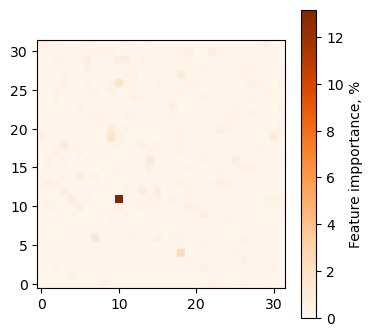

In [116]:
plot_fstr(all_fstr)

In [117]:
np.argmax(all_fstr)

2179

In [119]:
def get_opt_threshold(X, Y):

    best_t = 0.5
    best_f1 = -float('inf')
    
    for t in np.arange(0.5, 0.9, 0.001):
        pred = X > t
        f1 = f1_score(Y, pred)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    return best_t

In [120]:
groups = []

for i in range(NUM_TASKS):
    for j in range(25):
        groups.append(i)

kf = StratifiedGroupKFold(n_splits = 5, shuffle = True, random_state = 42)

splits = []

for train_idx, test_idx in kf.split(range(X.shape[0]), Y, groups):
    splits.append((train_idx, test_idx))

#pickle.dump(splits, open('/he_results2/splits.pickle', 'wb'))

In [121]:
pass1 = 0
pass10 = 0
cnt = 0

pass1_list = []
pass1_fold = 0
cnt_fold = 0

for fold in all_task_res:

    pass1_fold = 0
    cnt_fold = 0
    
    for task_pred in fold:
        pass1 += task_pred[0][1]
        pass10 += max([x[1] for x in task_pred[0:10]])
        #print(task_pred[0:5])
        cnt += 1
        
        pass1_fold += task_pred[0][1]
        cnt_fold += 1

    pass1_list.append(pass1_fold / cnt_fold)

In [122]:
np.mean(pass1_list), np.std(pass1_list)

(0.390530303030303, 0.060610795269604896)

In [123]:
pass1/cnt, pass10/cnt, cnt

(0.3902439024390244, 0.6463414634146342, 164)

### Baseline

In [124]:
pass1_list = []
pass10_list = []

for k in range(10000):

    pass1 = 0
    pass10 = 0
    cnt = 0
    
    for fold in all_task_res:
        for task_pred in fold:
            np.random.shuffle(task_pred)
            pass1 += task_pred[0][1]
            pass10 += max([x[1] for x in task_pred[0:10]])
            cnt += 1

    pass1_list.append(pass1 / cnt)
    pass10_list.append(pass10 / cnt)

In [125]:
np.mean(pass1_list), np.mean(pass10_list)

(0.25957926829268296, 0.6065353658536585)

In [126]:
# confidence interval

sorted(pass1_list)[-500], sorted(pass10_list)[-500]

(0.29878048780487804, 0.6402439024390244)

In [127]:
np.mean(run_stat)

0.25951219512195123

### Ranking

In [130]:
def calc_quality_rank(train_idx, test_idx):

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    probs_test = []

    train_info = []
    test_info = []
    test_task_nums = set()
    
    for i in range(X.shape[0]):
        if i in train_idx:
            X_train.append(X[i])
            y_train.append(Y[i])
            train_info.append(i // 25)
        else:
            X_test.append(X[i])
            y_test.append(Y[i])
            test_info.append(i // 25)
            probs_test.append(all_probs[i])
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
        
    clf = xgb.XGBRanker(tree_method="hist", objective = 'rank:ndcg', max_bin = 64, n_estimators = 1000, eta = 0.1)
    clf.fit(X_train, y_train, qid = train_info)
    y_pred = clf.predict(X_test)

    #
    #
    #
    task_res = {task_num : [] for task_num in set(test_info)}

    for i in range(len(test_info)):
        task_num = test_info[i]
        p = y_pred[i]
        task_res[task_num].append((p, y_test[i]))

    all_candidates = []

    for task_num in task_res:
        pred_list = task_res[task_num]
        pred_list_sorted = sorted(pred_list, key = lambda x : -x[0])
        #best_candidate = [x[1] for x in pred_list_sorted[0:1]]
    
        all_candidates.append(pred_list_sorted)

    #return accuracy_score(y_test, y_pred > 0.5), all_candidates
    return roc_auc_score(y_test, y_pred), all_candidates, clf

In [131]:
groups = []

for i in range(NUM_TASKS):
    for j in range(25):
        groups.append(i)

kf = StratifiedGroupKFold(n_splits = 5, shuffle = True, random_state = 42)
res_auc = []
all_clf = []
all_task_res = []

for train_idx, test_idx in kf.split(range(X.shape[0]), Y, groups):
    #print("%s %s" % (train_idx, test_idx))
    auc, task_res, clf = calc_quality_rank(train_idx, test_idx)
    res_auc.append(auc)
    all_clf.append(clf)
    all_task_res.append(task_res)

In [132]:
all_task_res

[[[(1.7724675, 1),
   (1.7724675, 1),
   (1.7724675, 1),
   (1.7212073, 1),
   (1.7212073, 1),
   (1.397526, 1),
   (1.2941633, 1),
   (1.0370013, 1),
   (1.0349333, 1),
   (0.9952719, 0),
   (0.8267756, 1),
   (0.6163061, 1),
   (0.5616706, 1),
   (0.48912868, 0),
   (0.48717806, 1),
   (0.38788682, 0),
   (0.33329138, 1),
   (0.22616537, 0),
   (0.13098845, 1),
   (0.08679495, 0),
   (0.022809748, 0),
   (-1.150273, 0),
   (-5.1235247, 0),
   (-5.2889967, 0),
   (-5.5257206, 0)],
  [(-0.49662703, 0),
   (-0.8287523, 0),
   (-0.8648321, 0),
   (-1.2633455, 0),
   (-1.3579319, 0),
   (-1.3628873, 0),
   (-2.1878989, 0),
   (-2.4425, 0),
   (-2.9362519, 0),
   (-3.1351097, 0),
   (-3.3483927, 0),
   (-3.7160978, 0),
   (-3.937877, 0),
   (-4.3826947, 0),
   (-4.588488, 0),
   (-4.7723064, 0),
   (-5.4328504, 0),
   (-5.6061845, 0),
   (-5.7969656, 0),
   (-5.817445, 0),
   (-5.9604335, 0),
   (-5.9662843, 0),
   (-6.035404, 0),
   (-6.092636, 0),
   (-6.592867, 0)],
  [(0.8324702, 0),
 

In [133]:
pass1 = 0
pass10 = 0
cnt = 0

pass1_list = []
pass1_fold = 0
cnt_fold = 0

for fold in all_task_res:

    pass1_fold = 0
    cnt_fold = 0
    
    for task_pred in fold:
        pass1 += task_pred[0][1]
        pass10 += max([x[1] for x in task_pred[0:10]])
        #print(task_pred[0:5])
        cnt += 1
        
        pass1_fold += task_pred[0][1]
        cnt_fold += 1

    pass1_list.append(pass1_fold / cnt_fold)

In [134]:
pass1 / cnt, pass10 / cnt

(0.39634146341463417, 0.6585365853658537)

In [135]:
for elem in sorted(list(enumerate(zip(all_clf[0].feature_importances_, f_names))), key = lambda x : -abs(x[1][0])):
    print(elem)

(1803, (0.019243568, '1803_answer_self_att_9_12'))
(1571, (0.012850509, '1571_mtd_a_h1_8_5'))
(335, (0.012376338, '335_mtd_a_h1_1_23'))
(4775, (0.011526586, '4775_mtd_a_h1_24_27'))
(1948, (0.010647941, '1948_mtd_a_h0_10_4'))
(2386, (0.008535755, '2386_mtd_a_h0_12_13'))
(2500, (0.008200855, '2500_mtd_a_h0_13_0'))
(5974, (0.008006152, '5974_mtd_a_h0_31_3'))
(2325, (0.007820447, '2325_answer_self_att_12_3'))
(1373, (0.007502101, '1373_mtd_a_h1_7_4'))
(4995, (0.007478351, '4995_answer_self_att_26_0'))
(197, (0.0072468296, '197_mtd_a_h1_1_0'))
(3856, (0.0069332463, '3856_mtd_a_h0_20_2'))
(5020, (0.0064430814, '5020_mtd_a_h0_26_4'))
(1393, (0.0064165466, '1393_mtd_b_h1_7_7'))
(2473, (0.006357448, '2473_mtd_b_h1_12_27'))
(5022, (0.0062943352, '5022_mtd_b_h0_26_4'))
(5959, (0.0062683974, '5959_mtd_b_h1_31_0'))
(4265, (0.0060243644, '4265_mtd_a_h1_22_6'))
(3754, (0.0056825415, '3754_mtd_a_h0_19_17'))
(2287, (0.0056590433, '2287_mtd_b_h1_11_28'))
(5723, (0.00535765, '5723_mtd_a_h1_29_25'))
(1380

### Plot barcodes

In [191]:
run_stat[14]

[1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]

In [192]:
# prompt_len, correct_prefixes[seq], diag_sum1, diag_sum, mtd1, mtd2

In [193]:
from barcodes import plot_barcodes

In [194]:
results14 = pickle.load(open('/he_results2/%d.pickle' % 14, 'rb'))

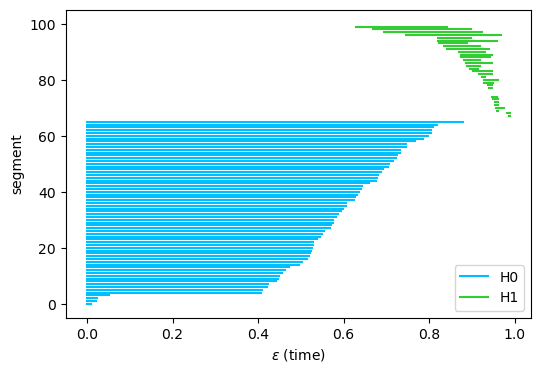

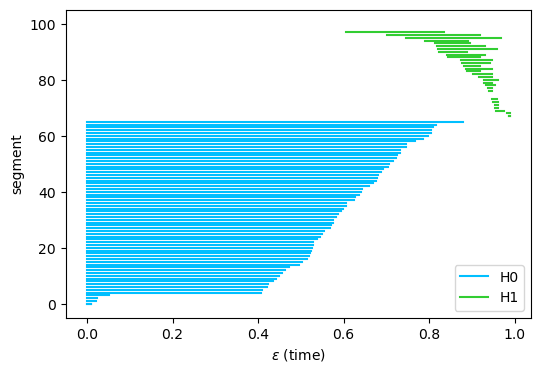

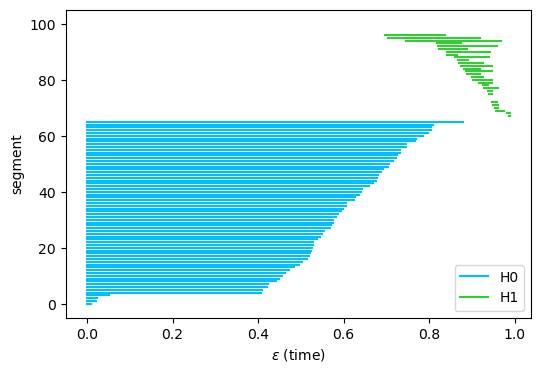

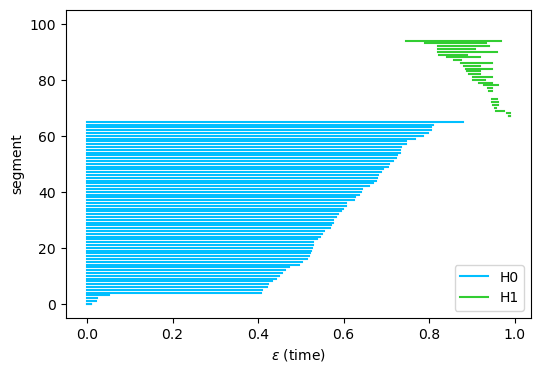

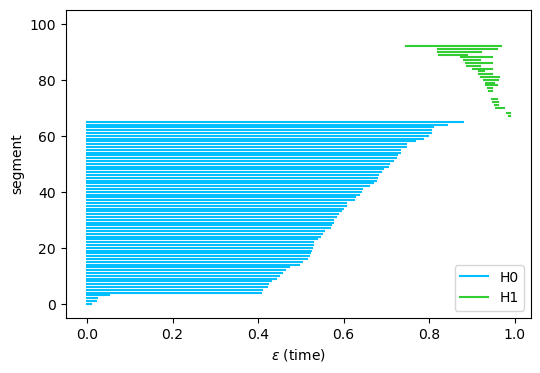

In [100]:
for seq in range(5):
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.set_ylim(-5, 105)
    dgms = results14[('HumanEval/14', 0, seq, 15, 5)][5]
    plot_barcodes([dgms['dgms'][0], dgms['dgms'][1]], ax = ax)
    plt.show()

In [ ]:
results14 = pickle.load(open('/he_results2/%d.pickle' % 14, 'rb'))

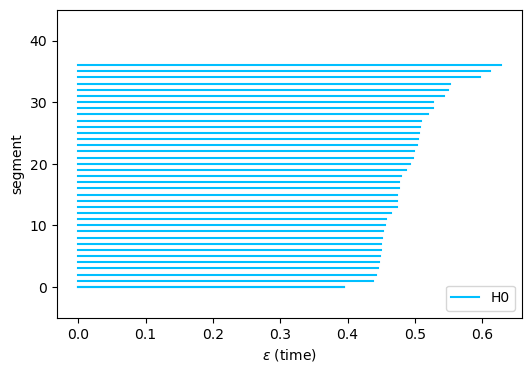

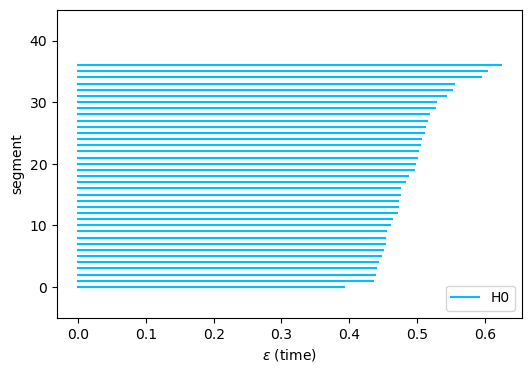

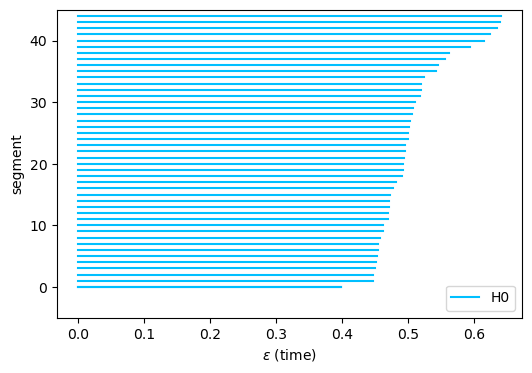

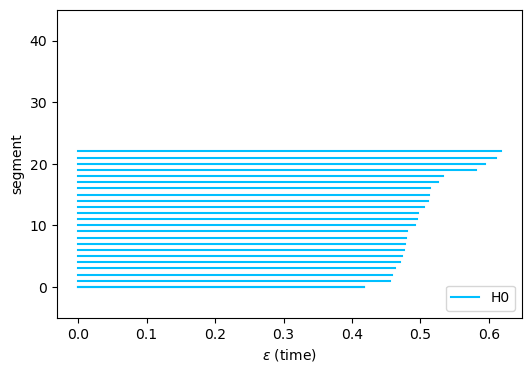

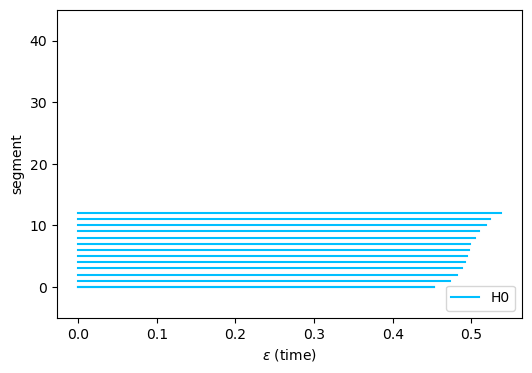

In [106]:
for seq in range(5):
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.set_ylim(-5, 45)
    dgms = results14[('HumanEval/14', 0, seq, 4, 18)][4]
    plot_barcodes([dgms['dgms'][0], dgms['dgms'][1]], ax = ax)

### Prompt & Generation len

In [198]:
def prepare_features_test():
    all_features = []

    for task_num in range(NUM_TASKS):
        features = []
        task_id = 'HumanEval/%d' % task_num
        for seed in range(5):
            for seq in range(num_samples_per_task):

                prompt_len = results[(task_id, 0, 0, 0, 0)][0]
                answer_len = results[(task_id, seed, seq, 0, 0)][1] - prompt_len
                f_sample = [prompt_len, answer_len] 
                
                all_features.append(f_sample)
    
    return all_features

In [199]:
X2 = prepare_features_test()

In [200]:
X2 = np.array(X2)

In [201]:
from collections import Counter
from sklearn.preprocessing import KBinsDiscretizer

(4100,)


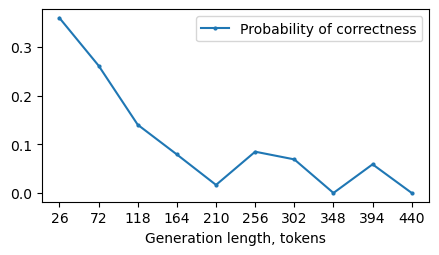

In [202]:
fig = plt.figure(figsize=(5, 2.5))

c1 = Counter()
c_all = Counter()
fnum = 1
    
data = X2[:, fnum]
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(data[..., np.newaxis])
data = est.transform(data[..., np.newaxis])
data = data[:, 0]

inv_data = est.inverse_transform(np.arange(10)[..., np.newaxis])

print(data.shape)

for elem in zip(data, Y):
    k, y = elem
    k = min(k, 20)
    
    c1[k] += y
    c_all[k] += 1

plt.plot(inv_data[:, 0], [c1[x] / c_all[x] for x in sorted(c1.keys())], 'o-', label = 'Probability of correctness', markersize = 2, alpha = 1)
plt.xlabel('Generation length, tokens')
#plt.ylabel('Probability of correctness')
#plt.legend(loc="upper left", bbox_to_anchor=(1.01,1.05))
plt.legend()
#plt.ylim((0, 0.3))
#sticks = [str(x) for x in list(range(0, 22, 2))]
#_ = plt.xticks(list(range(0, 22, 2)))
_ = plt.xticks(ticks = inv_data[:, 0], labels = [int(x) for x in inv_data[:, 0]])